# AIM

* 畳み込みニューラルネットワークでMNIST画像分類 with PyTorch

In [10]:
import datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.datasets import fetch_mldata

In [11]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "torch", "torchvision", "matplotlib", "scikit-learn"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
torch 0.2.0.post1
torchvision 0.1.9
matplotlib 2.0.2
scikit-learn 0.18.2


In [33]:
# モデルクラス定義

class CNN(nn.Module):
    def __init__(self):
        # クラスの初期化
        super(CNN, self).__init__()
        # 画像を畳み込みを行うまで
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(5, 5), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(5, 5), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 畳み込みで得られたベクトルを出力層に順伝播させるまで
        self.tail = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
    
    def __call__(self, x):
        # 順伝播を計算する関数
        # :param x: 入力値
        h = self.head(x)
        h = h.view(-1, 320)
        h = self.tail(h)
        y = F.log_softmax(h)
        return y

In [34]:
# 学習

EPOCH_NUM = 5
BATCH_SIZE = 1000
 
# 教師データ
mnist = fetch_mldata('MNIST original', data_home='.')
mnist.data = mnist.data.astype(np.float32) # 画像データ　784*70000 [[0-255, 0-255, ...], [0-255, 0-255, ...], ... ]
mnist.data /= 255 # 0-1に正規化する
mnist.target = mnist.target.astype(np.int32) # ラベルデータ70000
 
# 教師データを変換
N = 60000
train_x, test_x = np.split(mnist.data,   [N]) # 教師データ
train_t, test_t = np.split(mnist.target, [N]) # テスト用のデータ
train_x = train_x.reshape((len(train_x), IN_CHANNELS, 28, 28)) # (N, channel, height, width)
test_x = test_x.reshape((len(test_x), IN_CHANNELS, 28, 28))

# DataLoader化
train = torch.utils.data.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_t))
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_t))
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

# モデルの定義
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
    
# 学習開始
print("Train")
st = datetime.datetime.now()
for epoch in range(EPOCH_NUM):
    # ミニバッチ学習
    total_loss = 0
    for i, data in enumerate(train_loader):
        x, t = data
        x, t = Variable(x), Variable(t)
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, t)
        total_loss += loss.data[0]
        loss.backward()
        optimizer.step()
    if (epoch+1) % 1 == 0:
        ed = datetime.datetime.now()
        print("epoch:\t{}\ttotal loss:\t{}\ttime:\t{}".format(epoch+1, total_loss, ed-st))
        st = datetime.datetime.now()

Train
epoch:	1	total loss:	87.90769752860069	time:	0:00:25.185393
epoch:	2	total loss:	20.445800498127937	time:	0:00:24.952218
epoch:	3	total loss:	13.151168003678322	time:	0:00:25.736019
epoch:	4	total loss:	9.740851230919361	time:	0:00:25.274037
epoch:	5	total loss:	7.895347990095615	time:	0:00:24.455312



Predict


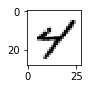

y:	4



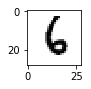

y:	6



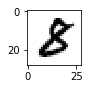

y:	8



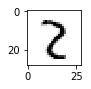

y:	2



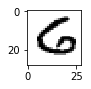

y:	6



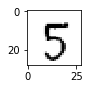

y:	5



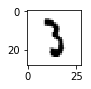

y:	3



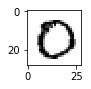

y:	0



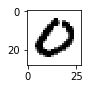

y:	0



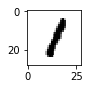

y:	1



In [38]:
# 予測

print("\nPredict")
def predict(model, x):
    x_ = np.array([x], dtype="float32")
    x_ = torch.from_numpy(x_)
    x_ = Variable(x_)
    y = model(x_)
    _, y = torch.max(y.data, 1)
    plt.figure(figsize=(1, 1))
    plt.imshow(x[0], cmap=cm.gray_r)
    plt.show()
    print("y:\t{}\n".format(y[0]))

idx = np.random.choice((70000-N), 10)
for i in idx:
    predict(model, test_x[i])